# Analyze RAGIS scalar timeseries

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os
import re

import seaborn as sns

from pismragis.observations import load_imbie
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [2]:
n_jobs = 2
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [3]:
# imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

## Make a list of all experiments

In [140]:
data_dir = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/"

sims = {
#     "GIMP": os.path.join(data_dir, "2023_07_gimp/scalar/ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
#     "RAGIS": os.path.join(data_dir, "2023_07_ragis/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
#     "RAGIS-CTRL": os.path.join(data_dir, "2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.45-200_1986-1-1_2000-1-1.nc"),
#     "RAGIS-FM": os.path.join(data_dir, "2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.45-200_1986-1-1_2000-1-1.nc"),
    "RAGIS-TW-CTRL": os.path.join(data_dir, "2023_07_ragis_tillwat/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
    "GIMP-TW-CTRL": os.path.join(data_dir, "2023_07_gimp_tillwat/scalar/ts_gris_g600m_v2023_GIMP_id_CTRL-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
    "GIMP-TW-FM": os.path.join(data_dir, "2023_07_gimp_tillwat/scalar/ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
    "RAGIS-TW-FM": os.path.join(data_dir, "2023_07_ragis_tillwat/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc"),
}

#     "scalar_dir": "scalar",
#     "processed_dir": "processed",


# sims = {"GIMP": {"proj_dir": "2023_07_gimp", "scalar_dir": "scalar", "file": "ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc"},
#         "RAGIS": "2023_07_ragis/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc",
#         "RAGIS-CTRL": "2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.45-200_1986-1-1_2000-1-1.nc",
#         "RAGIS-FM": "2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.45-200_1986-1-1_2000-1-1.nc",
#         "RAGIS-TW-CTRL": "2023_07_ragis_tillwat/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.50-200_1980-1-1_2020-1-1.nc",
#         "RAGIS-TW-FM": "2023_07_ragis_tillwat/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc",
# }

## Process experiments

In [141]:


exp_dfs = []
for sim_key, sim_val in sims.items():
    check_file(sim_val)
    df = ncfile2dataframe(sim_val, resample="yearly")
    exp_dfs.append(df)


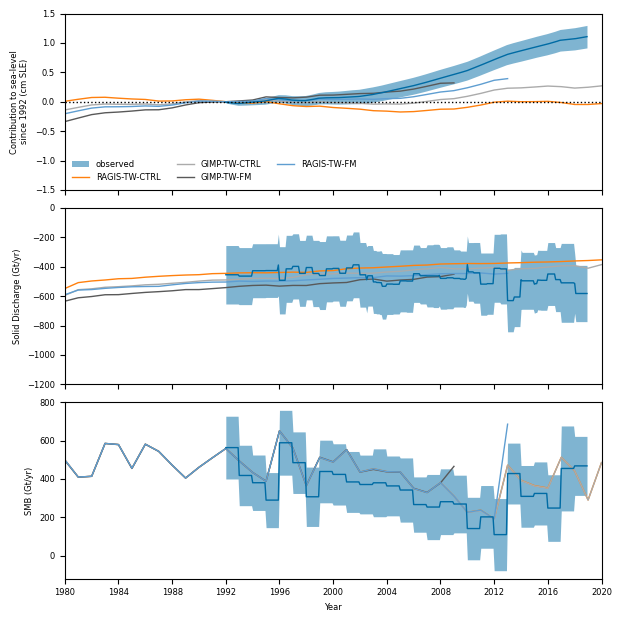

In [142]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 6.2))
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

obs_ci = axs[0].fill_between(imbie["Date"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5, label="observed")
axs[1].fill_between(imbie["Date"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)
axs[2].fill_between(imbie["Date"], 
                    (imbie[smb_varname] + sigma * imbie[smb_uncertainty_varname]), 
                    (imbie[smb_varname] - sigma * imbie[smb_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)

labels = []
for k, exp in enumerate(exp_dfs):
    sim_label = list(sims.keys())[k]
    axs[0].plot(exp["time"], exp[mass_varname], color=sim_colors[k], alpha=1.0, lw=1, label=sim_label)
    axs[1].plot(exp["time"], exp[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[2].plot(exp["time"], exp[smb_varname], color=sim_colors[k], alpha=1.0, lw=1)
    labels.append(l[0])

axs[0].plot(imbie["Date"], imbie[mass_varname], color=imbie_color, lw=1)
axs[1].plot(imbie["Date"], imbie[discharge_varname], color=imbie_color, lw=1)
axs[2].plot(imbie["Date"], imbie[smb_varname], color=imbie_color, lw=1)



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.5)
axs[1].set_ylim(-1200, 0)
#axs[1].set_ylim(-1000, 100)

legend = axs[0].legend(loc="lower left", ncols=3)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

In [122]:
list(sims.keys())

['GIMP',
 'RAGIS',
 'RAGIS-CTRL',
 'RAGIS-FM',
 'RAGIS-TW-CTRL',
 'GIMP-TW-CTRL',
 'GIMP-TW-FM',
 'RAGIS-TW-FM']

In [115]:
a.get_label()

'0     RAGIS-TW-FM\n1     RAGIS-TW-FM\n2     RAGIS-TW-FM\n3     RAGIS-TW-FM\n4     RAGIS-TW-FM\n5     RAGIS-TW-FM\n6     RAGIS-TW-FM\n7     RAGIS-TW-FM\n8     RAGIS-TW-FM\n9     RAGIS-TW-FM\n10    RAGIS-TW-FM\n11    RAGIS-TW-FM\n12    RAGIS-TW-FM\n13    RAGIS-TW-FM\n14    RAGIS-TW-FM\n15    RAGIS-TW-FM\n16    RAGIS-TW-FM\n17    RAGIS-TW-FM\n18    RAGIS-TW-FM\n19    RAGIS-TW-FM\n20    RAGIS-TW-FM\n21    RAGIS-TW-FM\n22    RAGIS-TW-FM\nName: label, dtype: object'

In [11]:
from pismragis.processing import ncfile2dataframe, check_file

In [19]:
dfs = []
for sim_key, sim_val in sims.items():
    df = ncfile2dataframe(sim_val)
    df["label"] = sim_key
    dfs.append(df)
exp_df = pd.concat(dfs)

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_gimp/scalar/ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.45-200_1986-1-1_2000-1-1.nc
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.45-200_1986-1-1_2000-1-1.nc


In [15]:
sims

{'GIMP': '/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_gimp/scalar/ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc',
 'RAGIS': '/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc',
 'RAGIS-CTRL': '/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.45-200_1986-1-1_2000-1-1.nc',
 'RAGIS-FM': '/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.45-200_1986-1-1_2000-1-1.nc'}

In [ ]:
sims

In [ ]:
*sims.values()

In [9]:
exp_df

,time,id,basal_mass_flux_floating (Gt year-1),basal_mass_flux_grounded (Gt year-1),dt (year),grounding_line_flux (Gt year-1),ice_area_glacierized (m2),ice_area_glacierized_cold_base (m2),ice_area_glacierized_floating (m2),ice_area_glacierized_grounded (m2),...,tendency_of_ice_mass_due_to_surface_mass_flux (Gt year-1),tendency_of_ice_mass_glacierized (Gt year-1),tendency_of_ice_volume (m3 year-1),tendency_of_ice_volume_glacierized (m3 year-1),Year,resolution_m,Mass (Gt),SLE (cm),D (Gt/yr),SMB (Gt/yr)
0,1980-01-02,FM-VCM-0.50-200,-642.741978,-4.643956,0.001708,-416.331816,1.752247e+12,1.252161e+12,5.605560e+09,1.746642e+12,...,969.819217,-30735.262404,-3.410247e+13,-3.377501e+13,1980.002732,600,-741.683961,0.204602,-416.331816,969.819217
1,1980-01-03,FM-VCM-0.50-200,-601.057925,-11.753448,0.001710,-410.769909,1.751595e+12,1.252274e+12,5.032080e+09,1.746563e+12,...,969.633802,-23194.337436,-2.544539e+13,-2.548828e+13,1980.005464,600,-741.946637,0.204675,-410.769909,969.633802
2,1980-01-04,FM-VCM-0.50-200,-569.210028,-11.772944,0.001711,-409.008254,1.751366e+12,1.252893e+12,4.829400e+09,1.746537e+12,...,969.483516,-17891.962129,-1.962239e+13,-1.966150e+13,1980.008197,600,-742.049674,0.204703,-409.008254,969.483516
3,1980-01-05,FM-VCM-0.50-200,-540.865697,-11.777163,0.001712,-419.779658,1.750975e+12,1.251961e+12,4.492080e+09,1.746483e+12,...,969.374378,-14808.941714,-1.624852e+13,-1.627356e+13,1980.010929,600,-742.620175,0.204861,-419.779658,969.374378
4,1980-01-06,FM-VCM-0.50-200,-518.645638,-12.022499,0.001714,-453.142945,1.750688e+12,1.252108e+12,4.226760e+09,1.746461e+12,...,969.313771,-12127.590664,-1.329654e+13,-1.332702e+13,1980.013661,600,-741.704960,0.204608,-453.142945,969.313771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,1999-12-28,FM-VCM-0.45-200,-93.183148,-10.698010,0.001940,-375.758330,1.693008e+12,1.208828e+12,4.914000e+08,1.692517e+12,...,588.013225,142.014383,1.693409e+11,1.560598e+11,1999.989041,600,729.463639,-0.201231,-375.758330,588.013225
5109,1999-12-29,FM-VCM-0.45-200,-93.236219,-10.632743,0.001939,-373.554402,1.693008e+12,1.208875e+12,4.903200e+08,1.692518e+12,...,588.012521,116.559399,1.432268e+11,1.280873e+11,1999.991781,600,730.150397,-0.201421,-373.554402,588.012521
5110,1999-12-30,FM-VCM-0.45-200,-93.053071,-10.622839,0.001939,-373.847282,1.693012e+12,1.208907e+12,4.921200e+08,1.692519e+12,...,588.011913,190.171420,2.211469e+11,2.089796e+11,1999.994521,600,730.546955,-0.201530,-373.847282,588.011913
5111,1999-12-31,FM-VCM-0.45-200,-93.305681,-10.696392,0.001939,-373.145626,1.693017e+12,1.208943e+12,4.932000e+08,1.692523e+12,...,588.011521,202.516180,2.314596e+11,2.225453e+11,1999.997260,600,730.992631,-0.201653,-373.145626,588.011521


Opening /Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_gimp/scalar/ts_gris_g600m_v2023_GIMP_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc
Opening /Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.45-200_1986-1-1_2000-1-1.nc
Opening /Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis/scalar/ts_gris_g600m_v2023_RAGIS_id_FM-VCM-0.50-200_1980-1-1_2020-1-1.nc
Opening /Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_07_ragis_fm/scalar/ts_gris_g600m_v2023_RAGIS_id_CTRL-VCM-0.45-200_1986-1-1_2000-1-1.nc
